# Recherche de similarité entre les images avec PyTorch à l'aide d'un Resnet18 

* Redimensionner les images
* Normalisation et vectorisation des images à l'aide du ResNet
* Recherche de similarité
* Test pour la similarité
* Visualisation des regroupements

source: https://towardsdatascience.com/recommending-similar-images-using-pytorch-da019282770c

In [1]:
#Import librairies

import torch
import os
import cv2
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from torchvision import models
import pandas as pd
import numpy as np
from numpy.testing import assert_almost_equal
import pickle
import matplotlib.pyplot as plt
import re

**1) Redimensionner les images**

Pour une meilleure application de l'algorithme

In [2]:
def Crop(path_in: str, path_out: str, h: float):


    if not os.path.isdir(path_out):
        os.mkdir(path_out)

    for root, dirs, files in os.walk(path_in):
        for f in tqdm(files):
            if f.endswith('.jpg'):
                filepath = os.path.join(root, f)
                img = cv2.imread(filepath)
                if img is not None:
                    #r = int(h) / img.shape[0]
                    #dim = (int(r * img.shape[1]), int(h))
                    dim = (int(h), int(h))
                    res = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
                    path_save = os.path.join(path_out + '/' + f)
                    cv2.imwrite(path_save, res)

In [3]:
# 224x224 est recommandé pour le ResNet-18

Crop(path_in= input('Enter path in : '), path_out=input('Enter path out : '), h= input('Enter width for resize : '))

Enter path in :  ../M_venus/corpus_art_img_C1
Enter path out :  ../M_venus/corpus_art_img_C1224
Enter width for resize :  224


100%|██████████| 6093/6093 [04:26<00:00, 22.88it/s]


**2) Normalisation et vectorisation des images à l'aide du ResNet**


In [2]:
# Set Directory et nom du corpus 
inputDir = " "
NAME = ' '

In [ ]:
# Implementation selon source

class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
        

#Générer un vecteur pour chaque image
img2vec = Img2VecResnet18() 

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir(inputDir)):
    if image.endswith('.jpg'):
        I = Image.open(os.path.join(inputDir, image))
        vec = img2vec.getVec(I)
        allVectors[image] = vec
        I.close() 

Converting images to feature vectors:


 87%|████████▋ | 5288/6092 [11:27<01:39,  8.09it/s]

**3) Recheche de similarité**

Utilisation de la métrique du cosinus

In [ ]:
def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix

In [ ]:
#Retour de la matrice

similarityMatrix = getSimilarityMatrix(allVectors)

In [ ]:
#similarityMatrix

**4) Test pour la similarité**

* Soit par le nombre d'images les plus proches
* Soit par regroupement à l'aide d'un KMeans

**Images les plus proches**

In [ ]:
k = 50 # nombre d'images le splus proches à stocker 

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values
    
#similarNames.to_pickle("similarNames.pkl")
#similarValues.to_pickle("similarValues.pkl")

In [ ]:
#similarNames.head()

In [ ]:
#similarValues.head()

In [ ]:
#Sauver matrices

similarityMatrix.to_csv('similarityMatrix_' + str(NAME) +'.csv')
similarValues.to_csv('similarValues_' + str(NAME) +'.csv')
similarNames.to_csv('similarNames_' + str(NAME) +'.csv')

**A l'aide d'une K-moyenne**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

In [ ]:
data = np.asarray(similarityMatrix)

In [ ]:
#Cohérence du nombre de regroupements

s = []
r = []
for i in tqdm(range(2, 20)):
    km = KMeans(n_clusters=i, init='k-means++').fit_predict(data)
    silhouette_avg = silhouette_score(data, km)
    s.append(silhouette_avg)
    r.append(i)
plt.figure(figsize=(28,12))
plt.xlabel("Nombre de regroupements")
plt.ylabel("Cohérence")
plt.title("Cohérence de chaque regroupement avec une K-moyenne")
plt.grid()
plt.plot(r, s, color = 'blue',
         linestyle = 'solid', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.savefig('choix_cluster_'+ str(NAME) + '.svg')             

**Sélectionner le nombre de regroupements possibles**

For n_clusters = 3 The average silhouette_score is : 0.17724925 Clusters : [[   0  745]
 [   1 2976]
 [   2 2371]]
For n_clusters = 4 The average silhouette_score is : 0.16175915 Clusters : [[   0 2812]
 [   1 1389]
 [   2 1336]
 [   3  555]]
For n_clusters = 6 The average silhouette_score is : 0.13067949 Clusters : [[   0  691]
 [   1 1551]
 [   2 1588]
 [   3  892]
 [   4  386]
 [   5  984]]
For n_clusters = 8 The average silhouette_score is : 0.12688053 Clusters : [[   0  895]
 [   1  590]
 [   2 1245]
 [   3 1103]
 [   4  263]
 [   5  818]
 [   6 1084]
 [   7   94]]


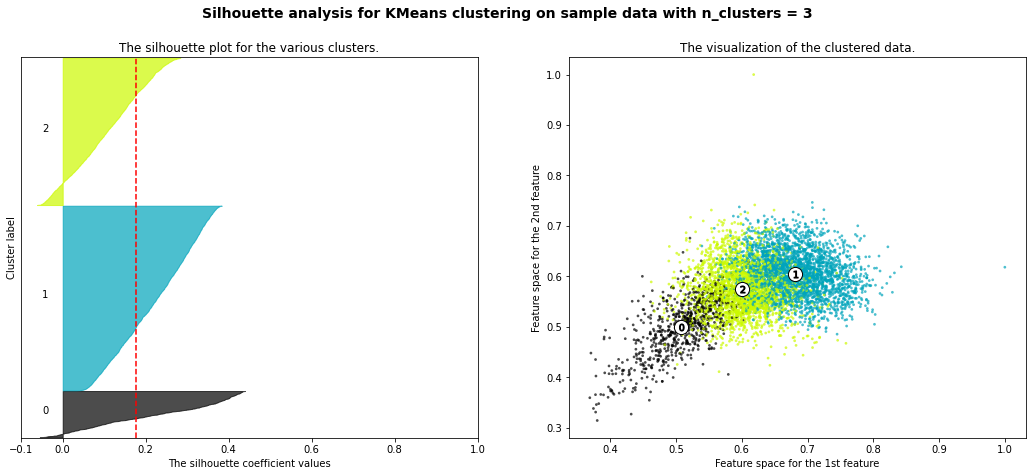

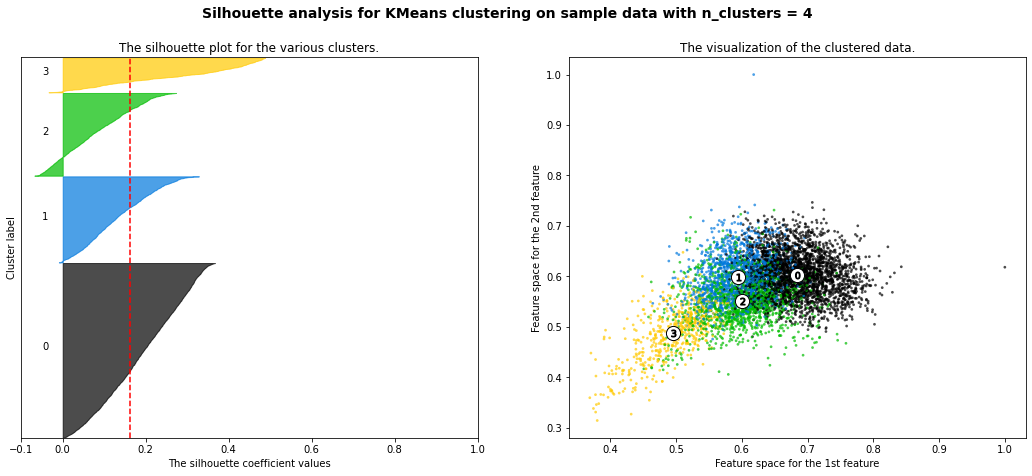

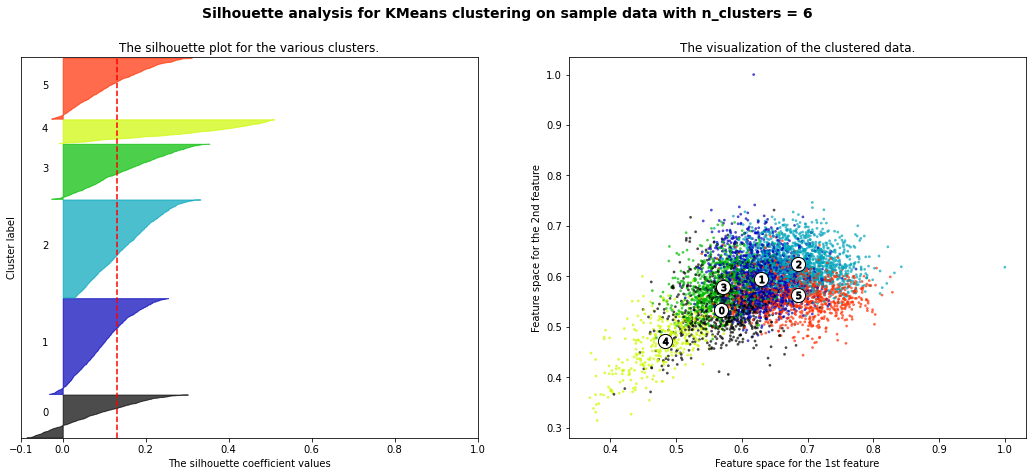

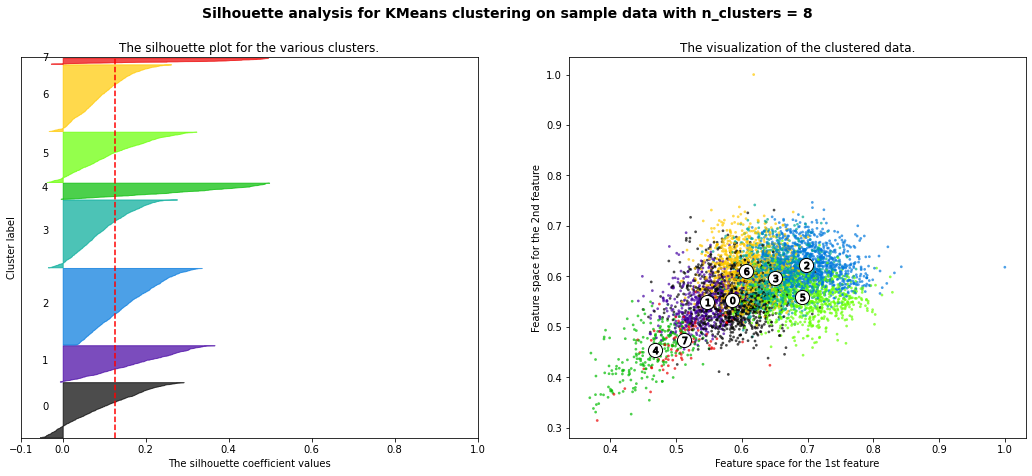

In [15]:
#Plot
#source : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

import matplotlib.cm as cm

X = data 

n = [ 3, 4, 6, 8]
for n_clusters in n:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++', random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    unique, frequency = np.unique(cluster_labels, 
                              return_counts = True)
    count = np.asarray((unique,frequency )).T
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg,
          "Clusters :", count)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.savefig('visualisation_cluster' + str(n_clusters) + '_' + str(NAME) + '.svg') 

plt.show()

In [ ]:
#Choisir le nombre définitif de regroupements

N = 2
model_sim = KMeans(n_clusters= N, init='k-means++').fit_predict(data)
scluster = pd.Series(model_sim, name ='Cluster')
unique, frequency = np.unique(model_sim, 
                              return_counts = True)
count = np.asarray((unique,frequency )).T
sname = pd.Series(similarNames.index, name ='Name')
df = pd.concat([scluster, sname],axis = 1)
print(f'Nombres d\'images par regroupement\n{count}')

In [ ]:
#Sauver la dataframe

df.to_csv('cluster_KMeans_' + str(NAME) + '_' + str(N) +'.csv')

**5) Visualisation des regroupements**

* Par nombre d'images les plus proches
* Par regroupements 

In [ ]:
#Visualiser les regroupements, par un dans le choix définitif

nc = 1 #Numéro du regroupement, attention début à 0 et non 1
df2 = df[df['Cluster'] == int(nc)]
limg = []
for i in df2.Name:
    p = os.path.join(inputDir + '/' + i)
    limg.append(p)

print(f'{len(limg)} images \nPremière image : {df2.Name.iloc[0]}')

In [ ]:
from PIL import Image

def display_images(
    images, name, columns=5, width=20, height=8):


    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        img = Image.open(image)
        img = img.convert('RGB')
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.imshow(img)
    
    plt.savefig(str(name))

In [ ]:
display_images(limg, name=('cluster_KMeans_' + str(NAME) + '_' + str(nc+1) + 'on' + str(N) +'.svg'))

In [ ]:
#Pour les images les plus proches
#Choisir une image

#inputImages = ["2019-06-27_23-28-41_UTC_1.jpg"]
inputImages = [df2.Name.iloc[0]]
print(f'Première image : {df2.Name.iloc[0]}')

In [ ]:
numCol = 5
numRow = 10

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 15) #[:2] après image pour label
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 10) #[:2] après image pour label
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, simiarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(22, 30))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open(os.path.join(inputDir, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            img = Image.open(os.path.join(inputDir, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()
    fig.savefig('cluster_sim_' + str(NAME) + '_' + str(nc+1) + 'on' + str(N) + '.svg')
        
for image in inputImages:
    plotSimilarImages(image, similarNames, similarValues)